In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import Ridge


%matplotlib inline

# 1. Загружаем данные из файла

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')

In [3]:
print('Количество строк или записей по обьектам составляет: ',df.shape[0])

Количество строк или записей по обьектам составляет:  48895


In [4]:
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


* id - идентификатор,
* name - название обьекта,
* host_id - идентификатор владельца,
* host_name - имя владельца,
* neighbourhood_group - район города,
* 'neighbourhoo - район'
* 'latitud - широата'
* 'longitud - долгота'
* 'room_typ - тип комнаты'
* 'pric - цена'
*  'minimum_nigh - минимальное количество ночейs
*  'number_of_revie - количество отзывовs
*  'last_revi - последний отзывw
*   'reviews_per_mo - отзывы за месяцt
* , 'calculated_host_listings_c - рассчитанное количество списков владельцевn
*    'availability - доступность 365.365'

#### Для нас является наиболее интересным столбец price - это цена за ночь пребывания.

# 2. Аннализ целевой переменной price

Столбец price - это наша целевая переменная y. Переменная y - это значение, которое мы будет стараться предсказать.

Первый шаг EDA - проверка распределения y! Построим гистограмму целевой функции. 

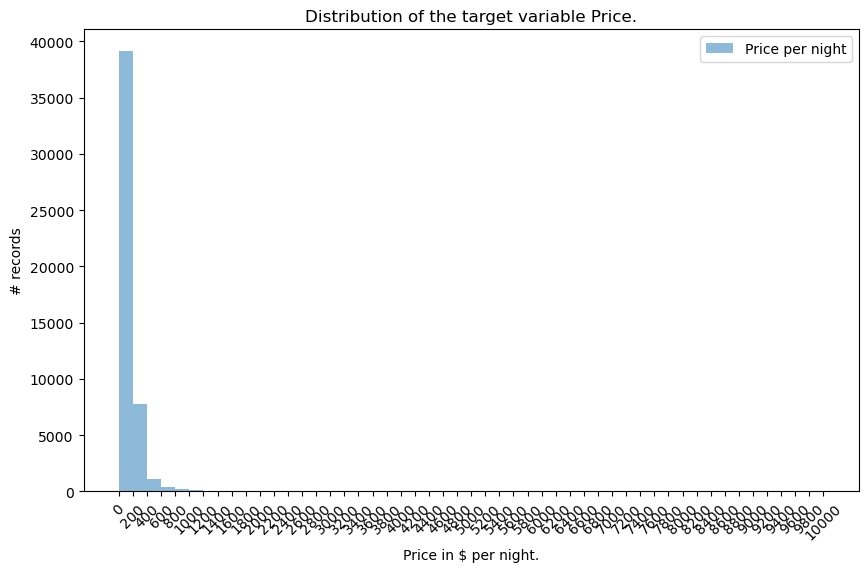

In [5]:
data = df['price']

fig, ax = plt.subplots(figsize = (10,6))

_,bins,_ = ax.hist(data, label = 'Price per night', alpha = 0.5, bins = 50)

ax.set_title('Distribution of the target variable Price.')
ax.set_xlabel('Price in $ per night.')
ax.set_ylabel('# records')
ax.set_xticks(bins)
ax.tick_params(axis='x', rotation = 45)
ax.legend()
plt.show()

Возглянув на график можно сразу же отметить, что распределение имеет очень длинный хвост справа. И график по сути нечитаем, поскольку большая часть обьектов недвижимости сдается по цене в диапазоне от нуля до 1000 доллларов, остальная часть обьектов сдается по высокой цене, но их весьма небольшое количесвто, такое что даже на нашем графике не видно. 

Так же мы можем взглянуть более подробно на участок с ценами от нуля дл 1000 долларов. 

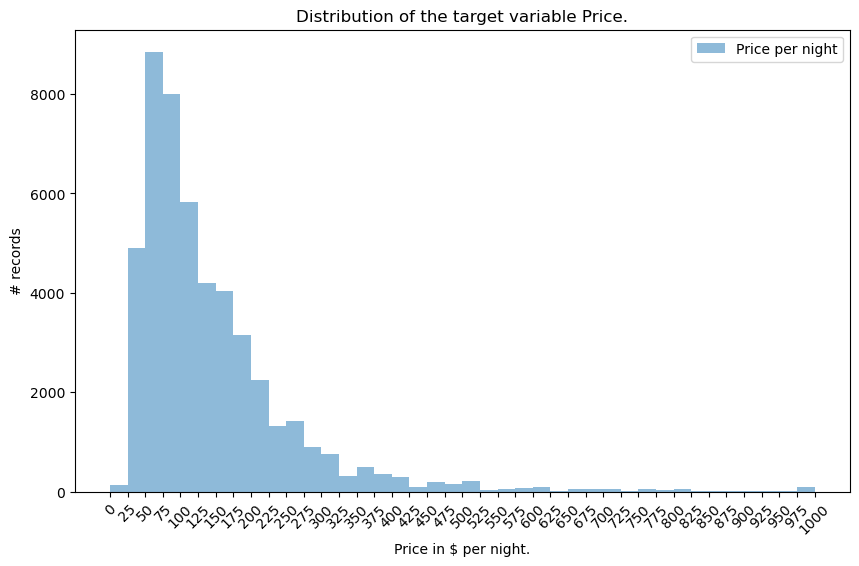

In [6]:
data = df[df['price'] < 1001]['price']

fig, ax = plt.subplots(figsize = (10,6))

_,bins,_ = ax.hist(data, label = 'Price per night', alpha = 0.5, bins = 40)

ax.set_title('Distribution of the target variable Price.')
ax.set_xlabel('Price in $ per night.')
ax.set_ylabel('# records')
ax.set_xticks(bins)
ax.tick_params(axis='x', rotation = 45)
ax.legend()
plt.show()

# 3. Посмотрим на распределения остальных фичей.

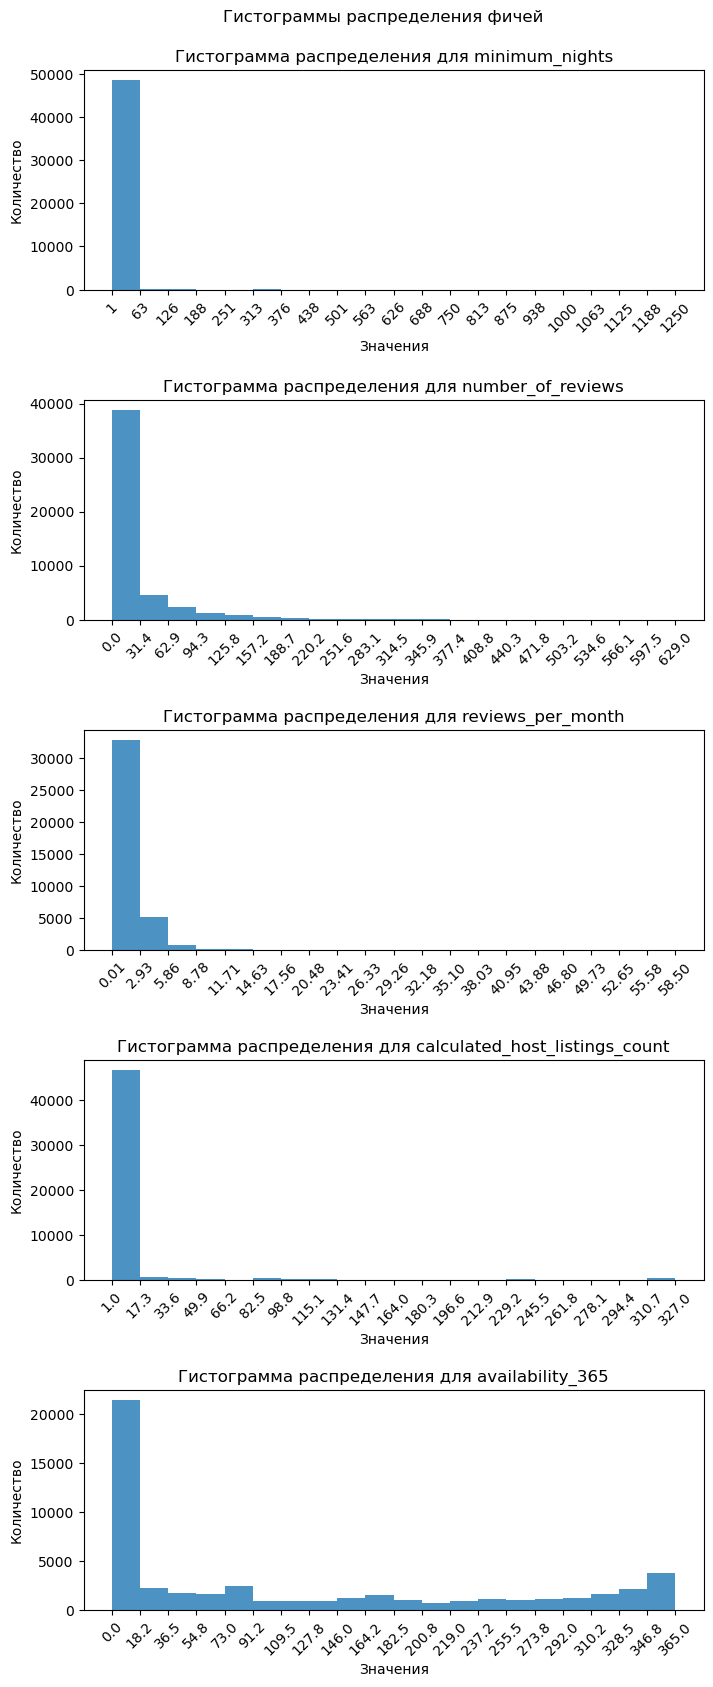

In [7]:
fig, ax = plt.subplots(nrows= 5, ncols= 1, figsize = (8, 20))

data_s = ['minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']

for i, feature in enumerate(data_s):
        data_S = df[feature]
        _,bins,_ = ax[i].hist(data_S, label = feature, alpha = 0.8, bins = 20)
        ax[i].set_title('Гистограмма распределения для ' + feature, y = 1)
        ax[i].set_ylabel('Количество')
        ax[i].set_xticks(bins)
        ax[i].tick_params(axis='x', rotation = 45)
        ax[i].set_xlabel('Значения')
                
fig.suptitle('Гистограммы распределения фичей', y = 0.91)
plt.subplots_adjust(hspace = 0.5)
plt.show()

Похоже что у наших распределений очень длинные хвосты. В дальнейшем это может негативно сказаться на качестве моели. 

# 4. Проверка наличия выбросов и зависимостей в данных.

Для начала посмотрим на наличие выбросов в наших фичах.

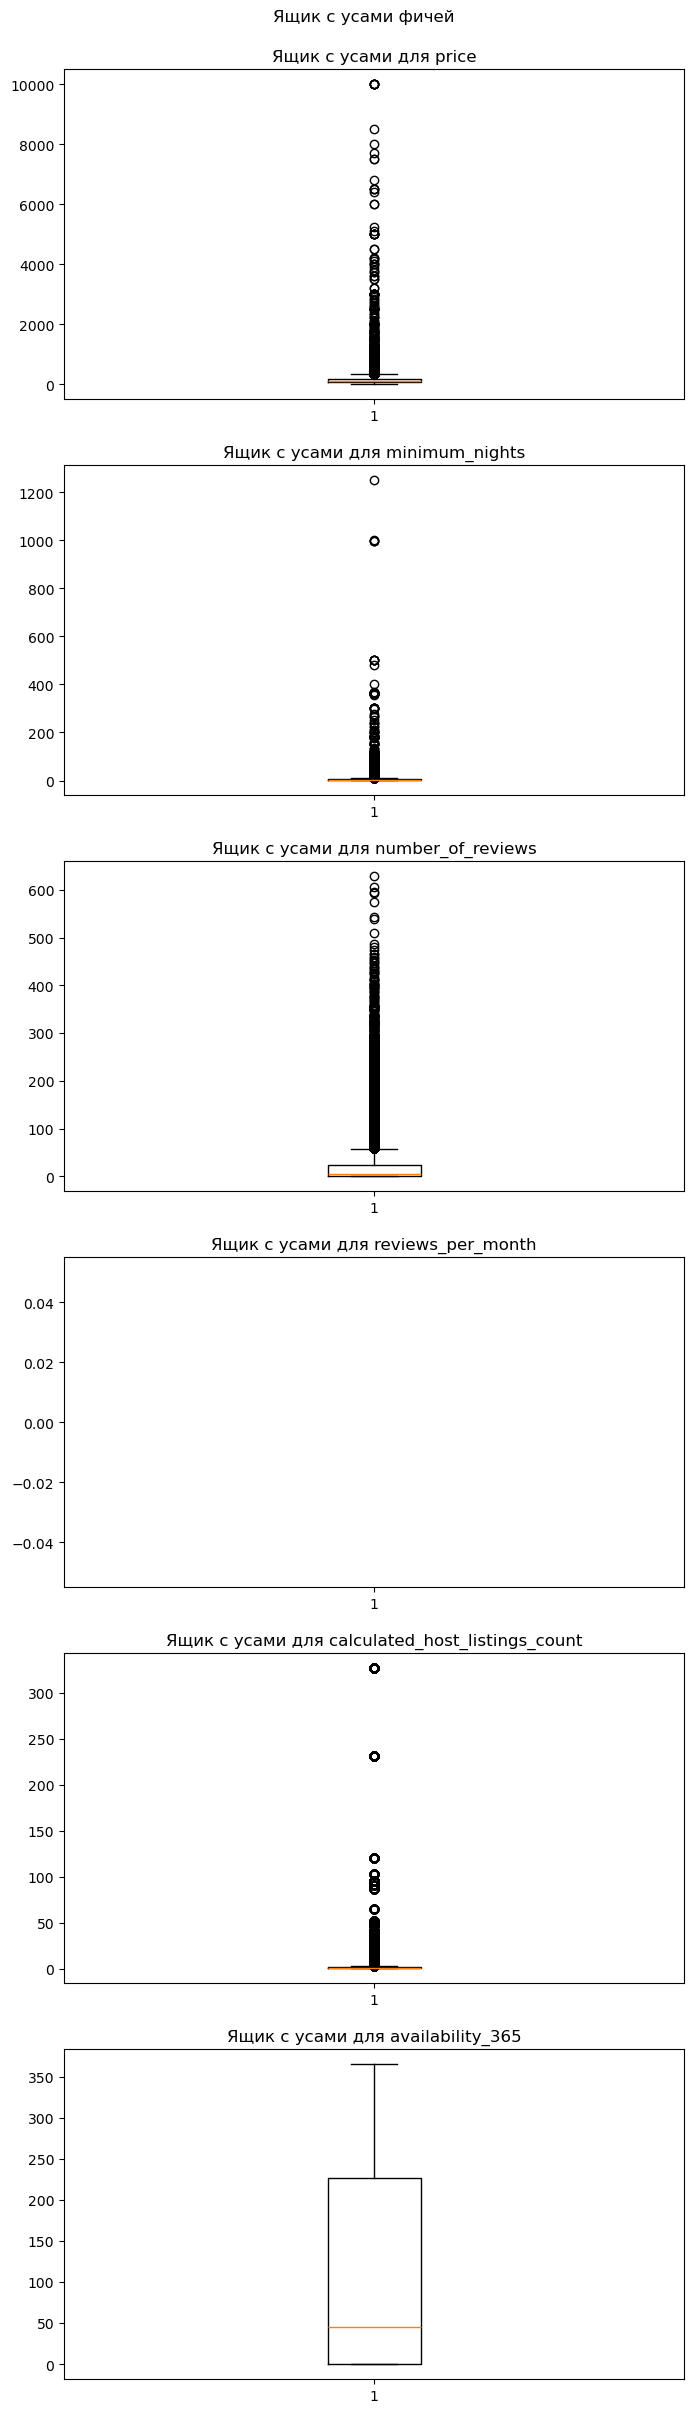

In [8]:
fig, ax = plt.subplots(nrows= 6, ncols= 1, figsize = (8, 30))

data_s = ['price','minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']

for i, feature in enumerate(data_s):
        data_S = df[feature]
        ax[i].boxplot(data_S)
        ax[i].set_title('Ящик с усами для ' + feature, y = 1)
                        
fig.suptitle('Ящик с усами фичей', y = 0.9)
plt.subplots_adjust(hspace = 0.2)
plt.show()

Как мы видим у нас огромное количество выбросов по всем фичам, кроме фичи "Доступность 365". Давайте посмотрим на наличие зависимостей фичей к цене.

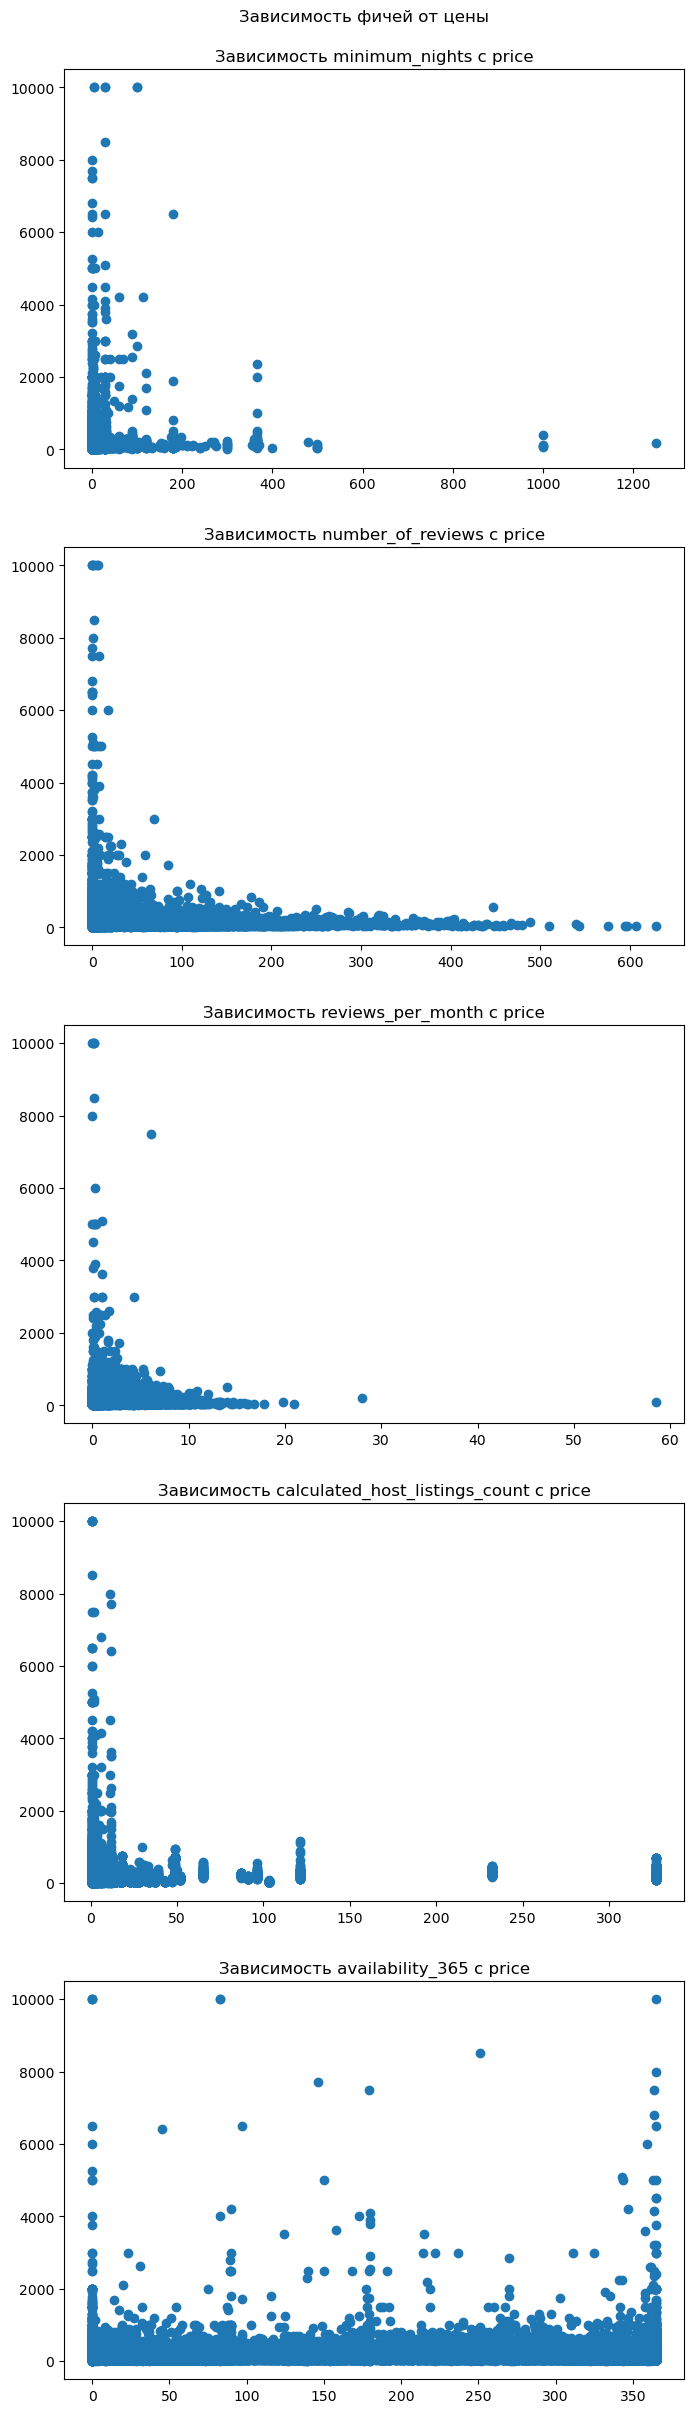

In [9]:
fig, axs = plt.subplots(nrows = 5, ncols = 1, sharey = True, figsize = (8,30)) # инициализируем график, сделаем общей ось У
#заведем два списка с издателми и жанрами  по которым мы будем итерировать
feature = ['minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']
main_feature = ['price']

for i, value in enumerate(feature):
    ax = axs[i]
    ax.scatter(df[value], df[main_feature], label = str(value) + 'с price')
    ax.set_title('Зависимость ' + str(value) + ' c price')

fig.suptitle('Зависимость фичей от цены', y = 0.9)            
plt.show()

Поскольку в данных много выбросов и есть наличие очень длинных хвостов - по графикам трудно определить зависимость, поэтому построим матрицу зависимостей.

In [10]:
pip install seaborn --upgrade

Note: you may need to restart the kernel to use updated packages.


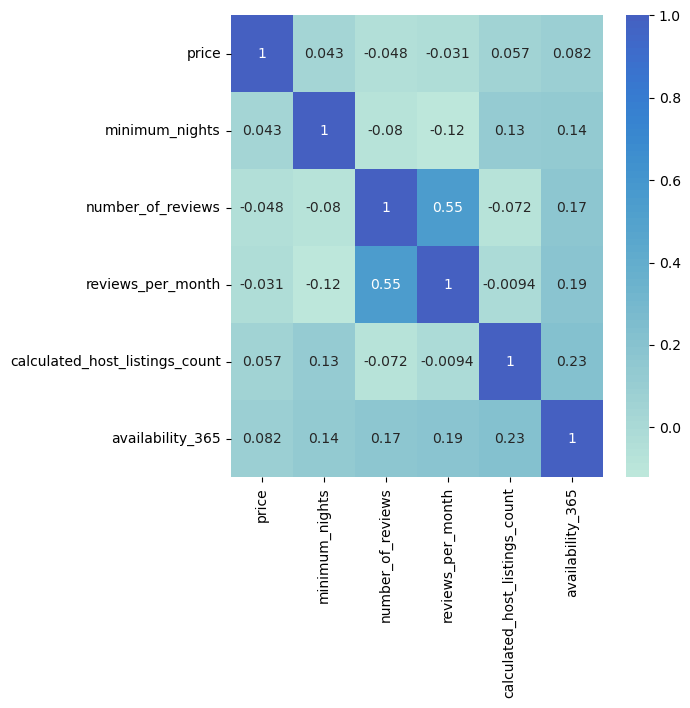

In [11]:
data_s = ['price','minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']
corr_m = df[data_s].corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr_m, center=2, annot=True)
plt.show()

И так мы видим что цена вообще не коррелирует ни с одной фичей.

# 5. Проверка пропущенных значений и их заполнение.

И так поскольку модели машинного обучения неумеют обрабатывать пропущенные значения, то нам необходимо определиться что с ними делать. Давайте для начала высним наличие пропущенных значений. 

In [12]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Мы видим пропущенные значение в полях название обьекта - 16 шутк и в именах хохяина - 21 пропушенное значение. И ОГРОМНОЕ количество пропущенных значений в полях последний отзыв и отзывы за месяц.  **ОЧЕНЬ ВАЖНО!** Поле price - несодержит пропущенных значений, ведь для нас важны для прогнозирования цены! И так ОГРОМНОЕ количество пропусков мы должны запомнить и перед обучением модели решить что с этим делать, но пока запомним, что у нас имеются пропущенные значения.

Иногда при работе с данными можно столкнуться с такой проблемой: в данных есть пропущенные значения, но удалять из таблицы строки с пропущенными значениями не хочется, поскольку в этих строках есть также заполненные ячейки с ценной информацией.

Хотя мы можем на это пойти и удалить данные - это является один из вариантов решения данной проблемы. 
Но еще можно заполнить недостающие значения нулями, в этом случае мы не будем терять ценнные значения из других ячеек, а перемноженные весовые коэфициенты с такими фичами все равно будут давать значения ноль.
Этот метод неиделаьно справляется с пропущенными значениями но часто работает хорошо. 

Альтенативные варианты - замены отсутсвющих значений средними. 

Поле last_review - содердит тип обьект, и как мы ранее видели там находится дата. Что же, для обучения мы не будем испольовать данный столбец поэтому смело можем заполнить его нулями. Поле reviews_per_month содердит числа с плавающей точкой, мы можем использовать этот столбец при обучении и и заполним его нулями. Имя и название обьектов слишком разннообразны и могут не явно влиять на результат обучения. Поэтому мы тоже для сохранения данных заполним значения нулями.  

In [13]:
df = df.fillna(0)
df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

# 6. Подготовка данных и их нормализация.

Мы не нашли зависимостей между фичами и прогназируемой переменной, но мы увидили длинные хвосты на графиках и значительное количество выбросов.

Очевидно, что следует применить методы обработки данных:

* **Удалить их:** просто убрать выбросы из набора данных, но это может потерять информацию.
* **Заменить на типичные значения:** заменить выбросы на более типичные значения, чтобы они не искажали результаты.
* **Использовать более устойчивые методы регрессии:** вместо обычной линейной регрессии можно использовать методы, которые менее чувствительны к выбросам, такие как робастная регрессия или методы типа Хьюбера. Эти методы учтут выбросы, но не дадут им слишком большой власти в модели.

#### Шкалирование и маштабирование

Когда необходимо шкалирование

Предположим, у нас есть набор данных о продажах автомобилей:

Одна переменная — это цена автомобиля. Может быть от нескольких тысяч до нескольких миллионов долларов.
Другая — количество проданных машин. Может варьироваться от нескольких штук до нескольких тысяч штук.
Если мы не будем масштабировать эти переменные, то модель линейной регрессии будет уделять больше внимания цене автомобиля, чем количеству проданных автомобилей. Это связано с тем, что цена автомобиля имеет более широкий диапазон значений.

В алгоритмах машинного обучения и анализа данных часто встречаются требования к входным данным, например: вероятностное распределение данных должно быть гауссовское или пуассоновское; данные должны быть в одинаковом масштабе. 

Перед аналитиком часто стоит задача трансформации входных данных таким образом, чтобы удовлетворить условия алгоритма. Игнорирование этих требований приводит к некорректным результатам. 

Трансформации применимы не только к фичам, но и к целевым переменным. 

При подготовке данных для обучения линейной регрессии применяются приёмы масштабирования и нормализации. 

Для борьбы с большими по модулю значениями, которые являются «выбросами», обычно используют: логарифмирование np.log; извлечение квадратного корня np.sqrt. 

Оба этих преобразования являются монотонными, то есть они меняют абсолютные значения, но сохраняют порядок величин. 

Пример немонотонного преобразования для величины 𝑥 — функция sin𝑥. Standart Scaling (Standartization, Z-score Normalization) — техника преобразования значений признака, адаптирующая признаки с разными диапазонами значений к Моделям (Model) Машинного обучения (ML), использующих дистанцию для прогнозирования. 

Эта разновидность нормализации с использованием стандартизированной оценки (Z-Score) преобразует значения таким образом, что из каждого Наблюдения (Observation) каждого Признака вычитается Среднее значение (Mean) и результат делится на Стандартное отклонение (Standard Deviation) этого признака. 

StandardScaler — класс в библиотеке sklearn, реализующий преобразование Z-Score: метод .fit() вычисляет внутренние коэффициенты для трансформации данных; метод .transform() трансформирует данные; метод .fit_transform() вычисляет внутренние коэффициенты для трансформации и возвращает трансформированные значения. Нормализация (Max-Min Normalization, Min-Max Scaling) — техника преобразования значений признака, масштабирующая значения таким образом, что они располагаются в диапазоне от 0 до 1:

Для того что бы убрать блинные хвосты есть такие методы как логорифмирование. Длинный хвост в целевой переменной очень сильно будет влиять на обучение модели. Один из способов решения этой проблемы служит логарифмическое преобразование. Преминив функцию log к ценам мы устраним этот нежелательный эффект.

y = log(y + 1), чать +1 нужна если в данных имеются занчения 0, поскольку логарифм нуля это минус бесконечность, но лагорифм единицы - ноль. 

#### Логорифмируем данные

In [14]:
data_s = ['price','minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']
df_for_normal = df[data_s]
log_df = np.log1p(df_for_normal)

Визуализируем данные после логарифмирования.

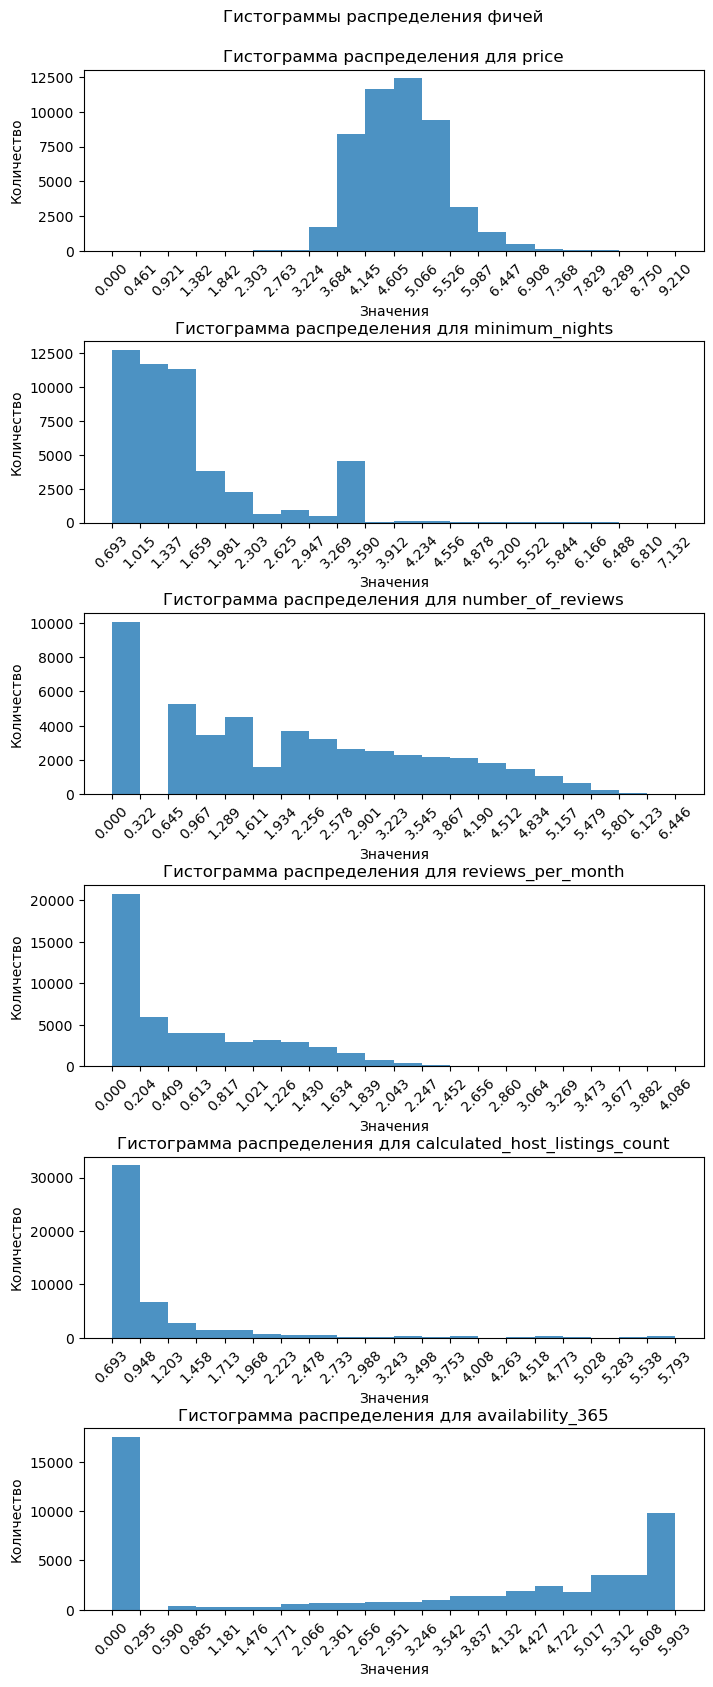

In [15]:
fig, ax = plt.subplots(nrows= 6, ncols= 1, figsize = (8, 20))

data_s = list(log_df.columns)

for i, feature in enumerate(data_s):
        data_S = log_df[feature]
        _,bins,_ = ax[i].hist(data_S, label = feature, alpha = 0.8, bins = 20)
        ax[i].set_title('Гистограмма распределения для ' + feature, y = 1)
        ax[i].set_ylabel('Количество')
        ax[i].set_xticks(bins)
        ax[i].tick_params(axis='x', rotation = 45)
        ax[i].set_xlabel('Значения')
                
fig.suptitle('Гистограммы распределения фичей', y = 0.91)
plt.subplots_adjust(hspace = 0.5)
plt.show()

#### StandardScaler

In [1]:
x_scaler =  StandardScaler() #создать экземпляр класса scaler=StandardScaler()
data_s = ['price','minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']
df_for_normal = df[data_s]
stand_scaled_df = x_scaler.fit_transform(df_for_normal)
print(stand_scaled_df.shape)

NameError: name 'StandardScaler' is not defined

In [17]:
stand_scaled_df = pd.DataFrame(stand_scaled_df, columns=['price','minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365'])
stand_scaled_df.head(3)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,-0.015493,-0.293996,-0.320414,-0.551511,-0.034716,1.916250
1,0.300974,-0.293996,0.487665,-0.445079,-0.156104,1.840275
2,-0.011329,-0.196484,-0.522433,-0.682986,-0.186451,1.916250


Вмзуализируем данные после нормализации.

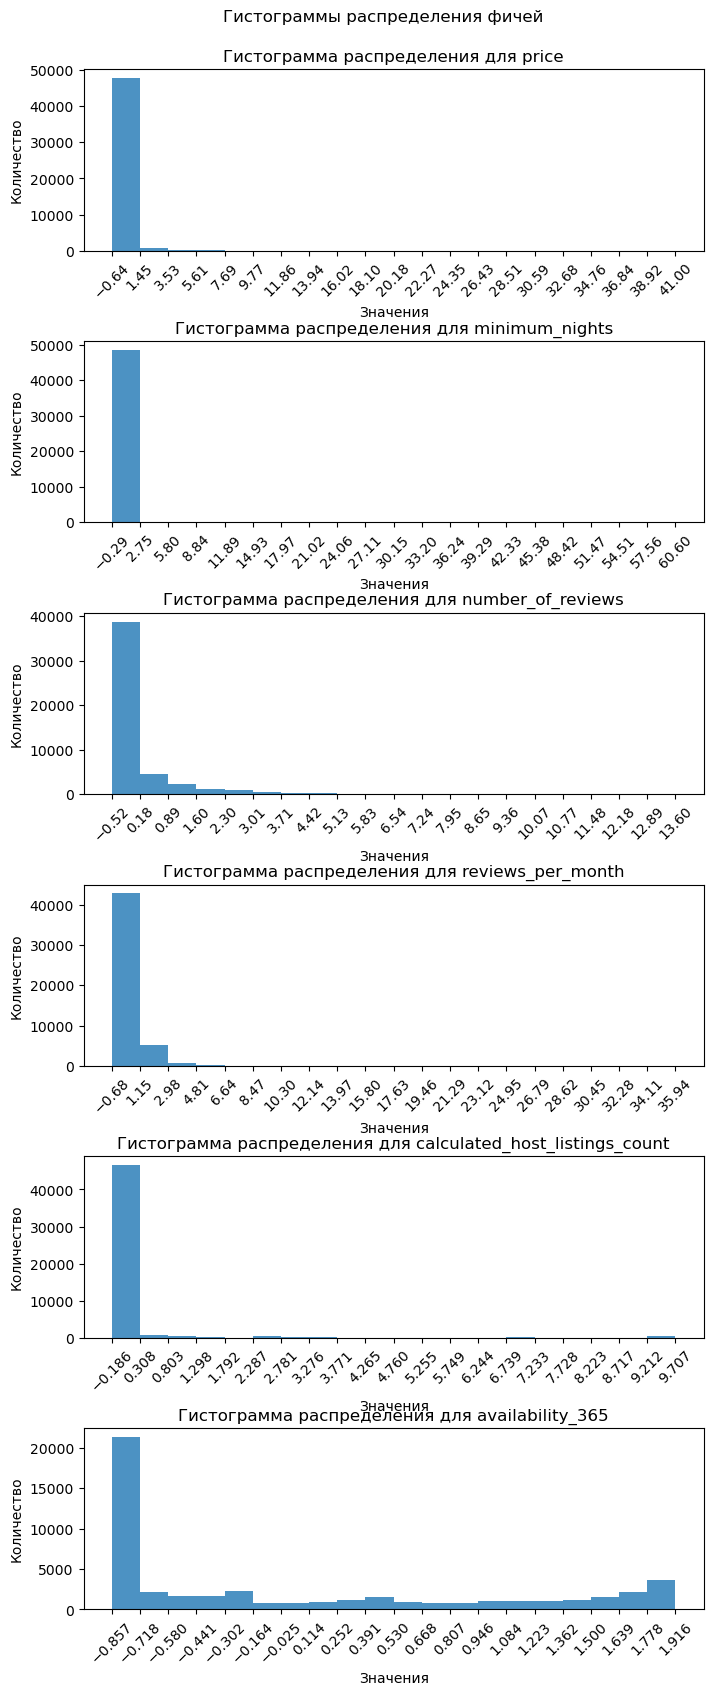

In [18]:
fig, ax = plt.subplots(nrows= 6, ncols= 1, figsize = (8, 20))

data_s = list(stand_scaled_df.columns)

for i, feature in enumerate(data_s):
        data_S = stand_scaled_df[feature]
        _,bins,_ = ax[i].hist(data_S, label = feature, alpha = 0.8, bins = 20)
        ax[i].set_title('Гистограмма распределения для ' + feature, y = 1)
        ax[i].set_ylabel('Количество')
        ax[i].set_xticks(bins)
        ax[i].tick_params(axis='x', rotation = 45)
        ax[i].set_xlabel('Значения')
                
fig.suptitle('Гистограммы распределения фичей', y = 0.91)
plt.subplots_adjust(hspace = 0.5)
plt.show()

#### min-max normalization

Другой распространённый метод называется MinMax Scaling. Этот метод переносит все точки на отрезок [0;1]

In [2]:
x_min_max_norm =  MinMaxScaler() #создать экземпляр класса scaler=StandardScaler()
data_s = ['price','minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']
df_for_normal = df[data_s]
min_max_df = x_min_max_norm.fit_transform(df_for_normal)
print(min_max_df.shape)

NameError: name 'MinMaxScaler' is not defined

In [20]:
min_max_df = pd.DataFrame(min_max_df, columns=['price','minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365'])
min_max_df.head(3)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0.0149,0.000000,0.014308,0.003590,0.015337,1.000000
1,0.0225,0.000000,0.071542,0.006496,0.003067,0.972603
2,0.0150,0.001601,0.000000,0.000000,0.000000,1.000000


Вмзуализируем данные после нормализации.

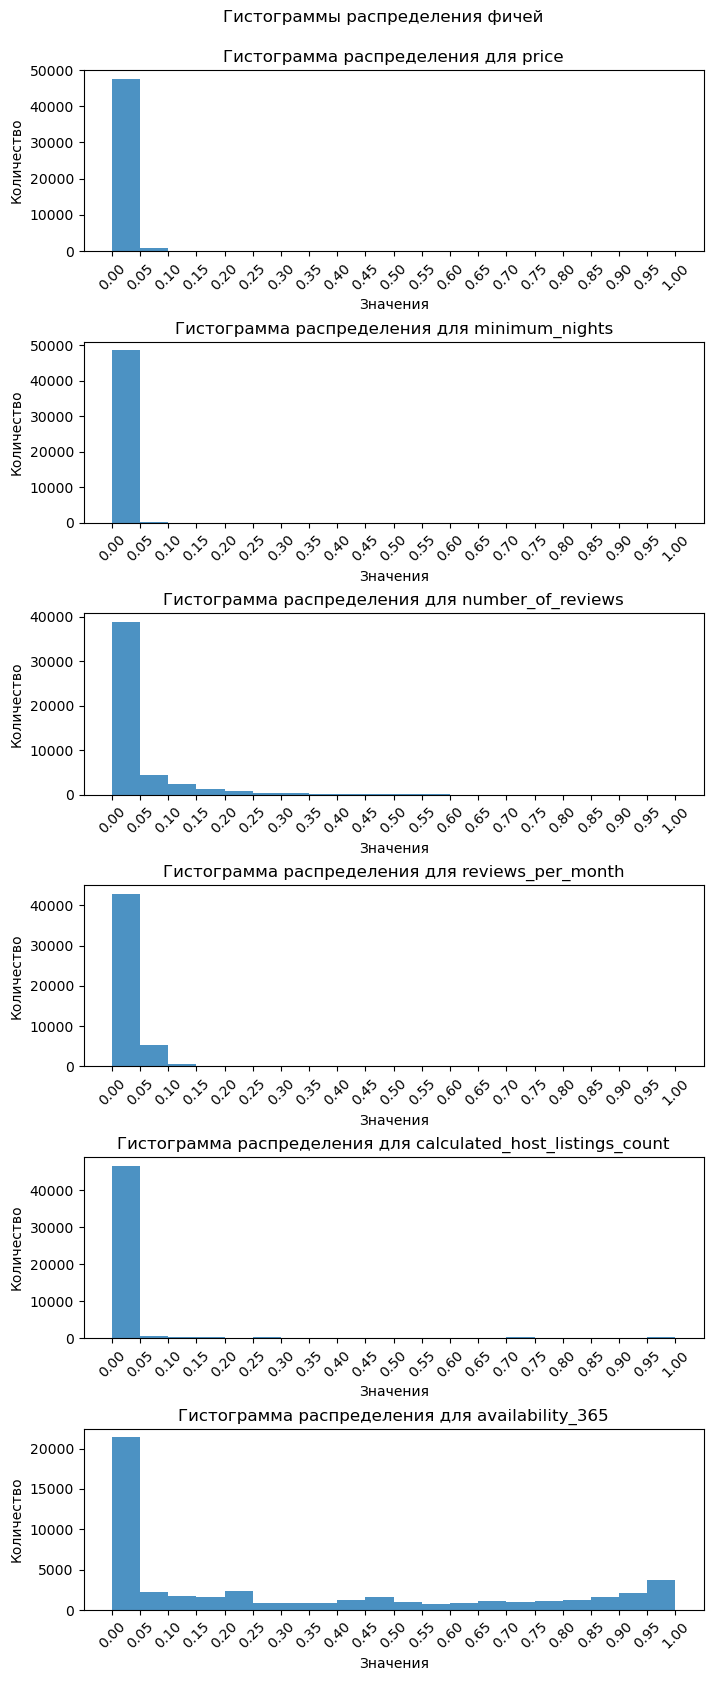

In [21]:
fig, ax = plt.subplots(nrows= 6, ncols= 1, figsize = (8, 20))

data_s = list(min_max_df.columns)

for i, feature in enumerate(data_s):
        data_S = min_max_df[feature]
        _,bins,_ = ax[i].hist(data_S, label = feature, alpha = 0.8, bins = 20)
        ax[i].set_title('Гистограмма распределения для ' + feature, y = 1)
        ax[i].set_ylabel('Количество')
        ax[i].set_xticks(bins)
        ax[i].tick_params(axis='x', rotation = 45)
        ax[i].set_xlabel('Значения')
                
fig.suptitle('Гистограммы распределения фичей', y = 0.91)
plt.subplots_adjust(hspace = 0.5)
plt.show()

# 7.Поделим весь набор данных на три части: обучающую, проверочную и тестовую.

#### Напишем фугкцию для разделения данных на тренировочную, валидационную и тестовую

In [22]:
def split_data(data):
    n = len(data)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    np.random.seed(3) #фиксируем начальное значение для воспроизводимости результатов
    idx = np.arange(n)
    np.random.shuffle(idx) #создаем массив с индексами от 0 до т-1 и перетасовываем его
    df_shuffled = data.iloc[idx] #используем массив с индексами для получения перетасованного датафрейма
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    y_train = df_train['price']
    del df_train['price']
    y_val = df_val['price']
    del df_val['price']
    y_test = df_test['price']
    del df_test['price']
    return df_train, y_train, df_val, y_val, df_test, y_test

#### Данные без преобразования:

In [23]:
data = df[['price','minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
df_train, y_train, df_val, y_val, df_test, y_test = split_data(data)

#### Логарифмированные данные

In [24]:
log_df_train, log_y_train, log_df_val, log_y_val, log_df_test, log_y_test = split_data(log_df)

#### Standart Scaling или Z-score nirmalization

In [25]:
sc_df_train, sc_y_train, sc_df_val, sc_y_val, sc_df_test, sc_y_test = split_data(stand_scaled_df)

#### Min - Max normalization

In [26]:
mm_df_train, mm_y_train, mm_df_val, mm_y_val, mm_df_test, mm_y_test = split_data(min_max_df)

# 8.У нас есть еще категориальные данные, задействуем и их!

Рассмотрим несколько на мой взгляд данных которые явно могут вляиять на цену.

In [27]:
pd.DataFrame(df.room_type.unique())

,0
0,Private room
1,Entire home/apt
2,Shared room


In [28]:
pd.DataFrame(df.neighbourhood_group.unique())

,0
0,Brooklyn
1,Manhattan
2,Queens
3,Staten Island
4,Bronx


In [29]:
pd.DataFrame(df.neighbourhood.unique())

,0
0,Kensington
1,Midtown
2,Harlem
3,Clinton Hill
4,East Harlem
...,...
216,Bull's Head
217,New Dorp
218,Rossville
219,Breezy Point


Из всех данных будем использовать тип комнаты и район. 

In [30]:
def prepare_cat_featues(df):
    base = ['price','minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365','room_type','neighbourhood_group']
    df = df.copy()
    features = base.copy()
    
    for v in ['Private room', 'Entire home/apt', 'Shared room']: #перечисляем наши категории
        feature = 'type_obj_%s' % v
        df[feature] = (df['room_type'] == v).astype(int)
        features.append(feature)

    for v in ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']: #перечисляем наши категории
        feature = 'neighbourhood_%s' % v
        df[feature] = (df['neighbourhood_group'] == v).astype(int)
        features.append(feature)
        
    total_df = df[features]
    return total_df

In [31]:
df_more_fit = prepare_cat_featues(df)
del df_more_fit['room_type']
del df_more_fit['neighbourhood_group']
df_more_fit.head(4)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,type_obj_Private room,type_obj_Entire home/apt,type_obj_Shared room,neighbourhood_Brooklyn,neighbourhood_Manhattan,neighbourhood_Queens,neighbourhood_Staten Island,neighbourhood_Bronx
0,149,1,9,0.21,6,365,1,0,0,1,0,0,0,0
1,225,1,45,0.38,2,355,0,1,0,0,1,0,0,0
2,150,3,0,0.00,1,365,1,0,0,0,1,0,0,0
3,89,1,270,4.64,1,194,0,1,0,1,0,0,0,0


#### Реализация средствами SkLearn

One-Hot encoding
Для преобразования категориальных переменных в числовые можно применять метод One-Hot encoding. Его алгоритм следующий:

* Для каждой категориальной переменной создается вектор.
* Для каждого компонента вектора присваивается значение 1, если значение категориальной переменной соответствует этому компоненту, и 0, если нет.
* Векторы объединяются в единый набор данных.

In [32]:
# Применяем One-Hot encoding с помощью функции get_dummies
base = ['price','minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365','room_type','neighbourhood_group']
df_for_example = df[base]
one_hot_encoded = pd.get_dummies(df_for_example, columns=['room_type', 'neighbourhood_group'], dtype = int) #заполняет нулями и единицами
one_hot_encoded.head(4)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,149,1,9,0.21,6,365,0,1,0,0,1,0,0,0
1,225,1,45,0.38,2,355,1,0,0,0,0,1,0,0
2,150,3,0,0.00,1,365,0,1,0,0,0,1,0,0
3,89,1,270,4.64,1,194,1,0,0,0,1,0,0,0


In [33]:
one_hot_encoded.shape

(48895, 14)

# 9.Нормализуем несколькими способами наш датафрейм с дополнительными фичами.

**Важно** Применять преобразования подобные стандартизации к категориальным/”булевым” признакам как минимум бесполезно, а как максимум — вредно. Поскольку может необоснованно увеличить или уменьшить их интервал значений. Поэтому мы просто присодиним даши данные к уже нормализованным данным.

#### Соединяем с данными без преобразования

In [34]:
data.shape

(48895, 6)

In [35]:
merged_df = pd.merge(data, one_hot_encoded.iloc[:,-8:-1], left_index=True, right_index=True)

In [36]:
merged_df_train, merged_df_Y_train, merged_df_val, merged_df_Y_val, merged_df_test, merged_df_Y_test = split_data(merged_df)

#### Соединяем с логарифмируемыми данными

In [37]:
log_df.shape

(48895, 6)

In [38]:
merged_log_df = pd.merge(log_df, one_hot_encoded.iloc[:,-8:-1], left_index=True, right_index=True)

In [39]:
merged_log_df_train, merged_log_df_Y_train, merged_log_df_val, merged_log_df_Y_val, merged_log_df_test, merged_log_df_Y_test = split_data(merged_log_df)

#### Содиняем с данными Stand scaled

In [40]:
stand_scaled_df.shape

(48895, 6)

In [41]:
merged_stand_scaled_df = pd.merge(stand_scaled_df, one_hot_encoded.iloc[:,-8:-1], left_index=True, right_index=True)

In [42]:
merged_stand_scaled_df_train, merged_stand_scaled_df_Y_train, merged_stand_scaled_df_val, merged_stand_scaled_df_Y_val, merged_stand_scaled_df_test, merged_stand_scaled_df_Y_test = split_data(merged_stand_scaled_df)

#### Соединяем с данными min - max normalizetion

In [43]:
min_max_df.shape

(48895, 6)

In [44]:
merged_min_max_df = pd.merge(min_max_df, one_hot_encoded.iloc[:,-8:-1], left_index=True, right_index=True)

In [45]:
merged_min_max_df_train, merged_min_max_df_Y_train, merged_min_max_df_val, merged_min_max_df_Y_val, merged_min_max_df_test, merged_min_max_df_Y_test = split_data(merged_min_max_df)

# 10.Оценка качества модели.

#### Реализуем линейную регрессию с помощью NumPy

In [46]:
def train_linear_regression(X, y):
    #создание массив единиц
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X]) # добавляем массив из единиц в качестве первого столбца
    #Формула нормального уравнения
    XTX = X.T.dot(X) # матричное перемножение Х с транспонированным Х
    XTX_inv = np.linalg.inv(XTX) # вычисляем обратную величину Х
    w = XTX_inv.dot(X.T).dot(y) 
    return w[0], w[1:]

Получим весовые коэфициенты и смещение

In [47]:
w_0, w = train_linear_regression(merged_df_train,merged_df_Y_train)

Получим предсказанные данные

In [48]:
y_pred = w_0 + merged_df_train.dot(w)

Визуализируем наше предсказание

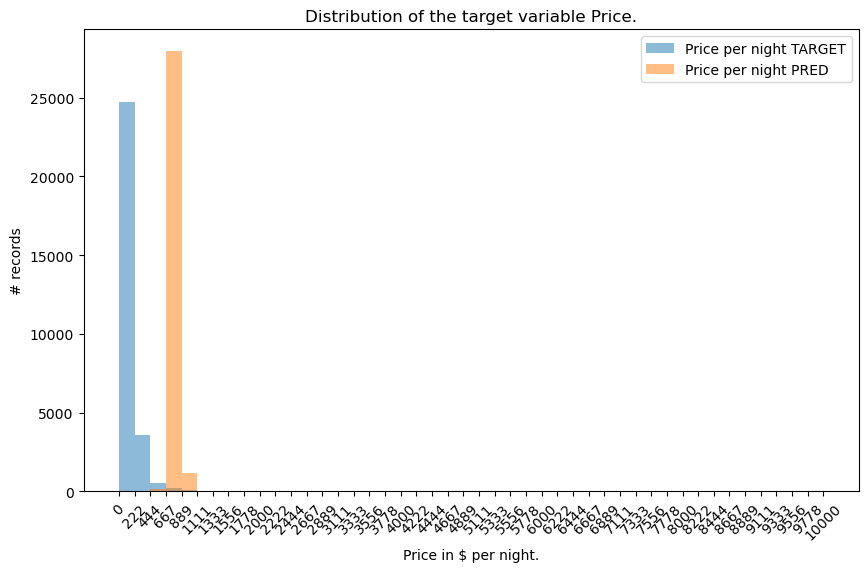

In [49]:
data0 = merged_df_Y_train
data1 = y_pred


fig, ax = plt.subplots(figsize = (10,6))

_,bins,_ = ax.hist(data0, label = 'Price per night TARGET', alpha = 0.5, bins = 45)
ax.hist(data1, label = 'Price per night PRED', alpha = 0.5, bins = bins)

ax.set_title('Distribution of the target variable Price.')
ax.set_xlabel('Price in $ per night.')
ax.set_ylabel('# records')
ax.set_xticks(bins)
ax.tick_params(axis='x', rotation = 45)
ax.legend()
plt.show()

#### RMSE оценка качества модели.

И так поскольку нам нужно будет постоянно что-то менять в модели, для ее улучшения то нам понадобится ее оценивать. Чаще всего с линейной регрессией используют корень среднеквадратичной ошибки RMSE.

In [50]:
def rmse(y_target, y_pred):
    error = y_pred - y_target
    mse = (error ** 2).mean()
    return np.sqrt(mse)

Получим ошибку из наших ранее полученных данных.

In [51]:
RMSE1 = rmse(merged_df_Y_train, y_pred)
RMSE1

669.8921184131194

Получаем 669.89 это означает, что в среднем прогнозы модели отклоняются на 669.89. Будем использовать эту метрику для сравнения разных моделей.

#### Mean square error

Mean square error - это отклонение истинных значений. **Чем ближе к нулю тем лучше!** Сильнее штрафует за большие ошибкие, чем функция MAE. T.e. если есть выбросы, то можно подумать, что модель плохо обучилась. И если убрать выбросы - то метрика сильно улучшится.

In [52]:
MSE = mean_squared_error(merged_df_Y_train,y_pred, squared=True) #(Если параметр squared равен True — вычисляется MSE, если False — RMSE).
MSE

448755.45031201676

In [53]:
RMSE = mean_squared_error(merged_df_Y_train,y_pred, squared=False) #(Если параметр squared равен True — вычисляется MSE, если False — RMSE).
RMSE

669.8921184131194

#### MAE

MSE, в отличии от MAE, более «пессимистична» и сильнее штрафует за большие ошибки — то есть MSE лучше применять, когда вы уверены, что в выборке нет «выбросов» (от англ. outliers) — значений, которые очень сильно отличаются от остальных точек. В этом случае MSE может быть очень плохой, но ситуация при этом приемлемой. **Если «выбросы» есть, лучше применять MAE.**

In [54]:
MAE = mean_absolute_error(merged_df_Y_train,y_pred)
MAE

640.6687687607894

#### $R^2$ (коэффициент детерминации)

Название - калька английского термина *coefficient of determination*. **Наилучшее возможное значение 1.0**, чем меньше тем хуже. Если этот коэффициент близок к 1, то условная дисперсия модели (то есть разброс предсказаний модели $\hat{y}$ относительно разброса самой целевой переменной $y$ ) достаточно мала - то есть модель неплохо описывает данные. Коэффициент может быть даже отрицательным - то это значит, что модель совсем уж плохая.

Эта метрика хороша тем, что она *нормализована*, то есть не превышает единицу - удобно сравнивать разные модели. Например, метрика $MSE$ может принимать ничем не ограниченные значения больше нуля - это не всегда удобно.

In [55]:
r2score = r2_score(merged_df_Y_train,y_pred)
r2score

-6.395932664515678

# 11.Напишем класс который реализует модель и содержит функции по подсчету метрик.

Существует множество библиотек языка Python с надежными
реализациями широкого диапазона алгоритмов машинного обучения,
которые можно условно разделить на три группы: 1) библиотеки,
предназначенные для использования Python с технологиями больших
данных (PySpark, PyDoop, Hadoopy); 2) библиотеки, предназначенные
для оптимизации кода (PyCUDA, Cython, Blaze, PP, Dispy, IPCluster и
другие); 3) библиотеки, предназначенные для работы с данными (Pandas, matplottib, NumPy, SymPy, SciPy, Scikit-Learn, TensorFlow, StatsModels, RPy2, NLTK и другие).

#### Попробуем сделать тоже самое с помощью линейной регрессии из библиотеки Scikit-Learn

In [56]:
class LinReg:
    def __init__(self, df_train, y_train, df_val, y_val, df_test, y_test, name):
        self.df_train = df_train
        self.y_train = y_train
        self.df_val = df_val
        self.y_val = y_val
        self.df_test = df_test
        self.y_test = y_test
        self.model = LinearRegression()
        self.name = name

    def fit(self):
        self.model.fit(self.df_train, self.y_train)
        print('Модель {model}, обучена.'.format(model=self.name))

    def predict(self):
        return self.model.predict(self.df_val)

    def loss(self):
        MSE = mean_squared_error(self.predict(), self.y_val, squared=True)
        RMSE = mean_squared_error(self.predict(), self.y_val, squared=False)
        MAE = mean_absolute_error(self.predict(), self.y_val)
        r2score = r2_score(self.predict(), self.y_val)
        print('Модель {model_name}.\n'.format(model_name=self.name))
        print('Оценки модели на валидационной выборке:\n'
              'MSE: {MSE} Лучше применять, когда выборке нет «выбросов» (от англ. outliers)\n'
              'RMSE: {RMSE} Чем ближе к нулю тем лучше! Если убрать выбросы - то метрика сильно улучшится.\n'
              'MAE: {MAE} Если «выбросы» есть, лучше применять MAE.\n'
              'r2score: {r2score} Наилучшее возможное значение 1.0. Если отрицательный - модель совсем уж плохая.'
              '\n'.format(MSE=MSE, RMSE=RMSE, MAE=MAE, r2score=r2score))

**Обучим модель линейной регрессии  на всех наших подготовленных данных (всего у нас 8 наборов) и выведим метрики.**

#### Данные без преобразования:

In [57]:
d_1 = {'df_train':df_train, 'y_train':y_train,
       'df_val':df_val,'y_val':y_val,
       'df_test':df_test,'y_test':y_test,
       'name':'Необработанные данные',
      'object':'d_1'}

#### Логарифмированные данные

In [58]:
d_2 = {'df_train':log_df_train, 'y_train':log_y_train,
       'df_val':log_df_val,'y_val':log_y_val,
       'df_test':log_df_test,'y_test':log_y_test,
       'name':'Логорифмированные данные',
      'object':'d_2'}

#### Standart Scaling или Z-score nirmalization

In [59]:
d_3 = {'df_train':sc_df_train, 'y_train':sc_y_train,
       'df_val':sc_df_val,'y_val':sc_y_val,
       'df_test':sc_df_test,'y_test':sc_y_test,
       'name':'Standart Scaling или Z-score nirmalization',
      'object':'d_3'}

#### Min - Max normalization

In [60]:
d_4 = {'df_train':mm_df_train, 'y_train':mm_y_train,
       'df_val':mm_df_val,'y_val':mm_y_val,
       'df_test':mm_df_test,'y_test':mm_y_test,
       'name':'Min - Max normalization',
      'object':'d_4'}

#### Данные без преобразования с новыми фичами

In [61]:
d_1_1 = {'df_train':merged_df_train, 'y_train':merged_df_Y_train,
       'df_val':merged_df_val,'y_val':merged_df_Y_val,
       'df_test':merged_df_test,'y_test':merged_df_Y_test,
       'name':'Данные без преобразования с новыми фичами',
      'object':'d_1_1'}

#### Логарифмируемые данные с новыми фичами

In [62]:
d_2_1 = {'df_train':merged_log_df_train, 'y_train':merged_log_df_Y_train,
       'df_val':merged_log_df_val,'y_val':merged_log_df_Y_val,
       'df_test':merged_log_df_test,'y_test':merged_log_df_Y_test,
       'name':'Логарифмируемые данные с новыми фичами',
      'object':'d_2_1'}

#### Standart Scaling или Z-score nirmalization с новыми фичами

In [63]:
d_3_1 = {'df_train':merged_stand_scaled_df_train, 'y_train':merged_stand_scaled_df_Y_train,
       'df_val':merged_stand_scaled_df_val,'y_val':merged_stand_scaled_df_Y_val,
       'df_test':merged_stand_scaled_df_test,'y_test':merged_stand_scaled_df_Y_test,
       'name':'Standart Scaling или Z-score nirmalization с новыми фичами',
      'object':'d_3_1'}

#### Min - Max normalization с новыми фичами

In [64]:
d_4_1 = {'df_train':merged_min_max_df_train, 'y_train':merged_min_max_df_Y_train,
       'df_val':merged_min_max_df_val,'y_val':merged_min_max_df_Y_val,
       'df_test':merged_min_max_df_test,'y_test':merged_min_max_df_Y_test,
       'name':'Min - Max normalization с новыми фичами',
      'object':'d_4_1'}

In [65]:
list_of_models =[d_1, d_2, d_3, d_4, d_1_1, d_2_1, d_3_1, d_4_1]

In [66]:
list_of_instance_class = []
for data in list_of_models:
    instace = LinReg(
        df_train = data.get('df_train'), 
        y_train = data.get('y_train'), 
        df_val = data.get('df_val'), 
        y_val = data.get('y_val'), 
        df_test = data.get('df_test'), 
        y_test = data.get('y_test'), 
        name = data.get('name')
    )
    instace.fit()
    instace.loss()
    list_of_instance_class.append(instace)   
    

Модель Необработанные данные, обучена.
Модель Необработанные данные.

Оценки модели на валидационной выборке:
MSE: 75206.87857423659 Лучше применять, когда выборке нет «выбросов» (от англ. outliers)
RMSE: 274.23872551891094 Чем ближе к нулю тем лучше! Если убрать выбросы - то метрика сильно улучшится.
MAE: 91.00879167798686 Если «выбросы» есть, лучше применять MAE.
r2score: -84.25556723628864 Наилучшее возможное значение 1.0. Если отрицательный - модель совсем уж плохая.

Модель Логорифмированные данные, обучена.
Модель Логорифмированные данные.

Оценки модели на валидационной выборке:
MSE: 0.4639693473755187 Лучше применять, когда выборке нет «выбросов» (от англ. outliers)
RMSE: 0.6811529544643543 Чем ближе к нулю тем лучше! Если убрать выбросы - то метрика сильно улучшится.
MAE: 0.5382912878416183 Если «выбросы» есть, лучше применять MAE.
r2score: -41.71827396431094 Наилучшее возможное значение 1.0. Если отрицательный - модель совсем уж плохая.

Модель Standart Scaling или Z-score ni

Визуализируем полученные резулитаты для лучшей интерпретации.

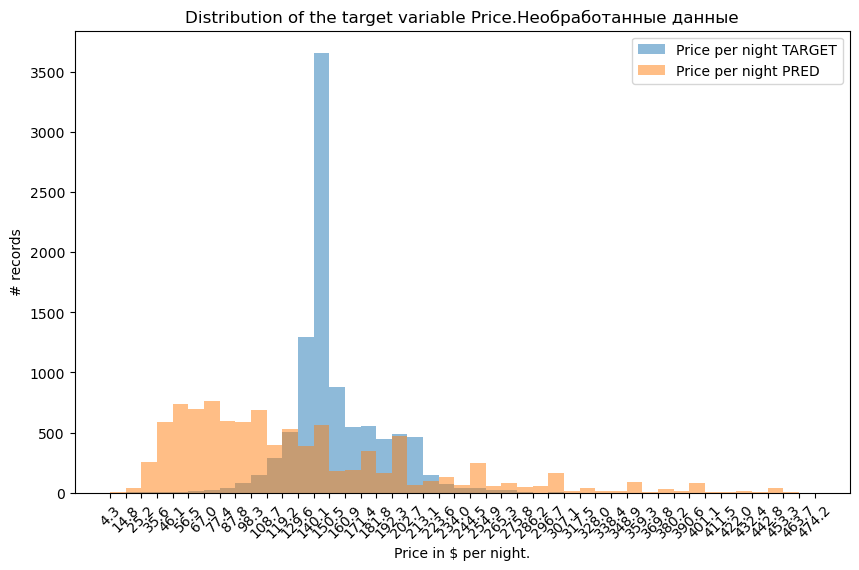

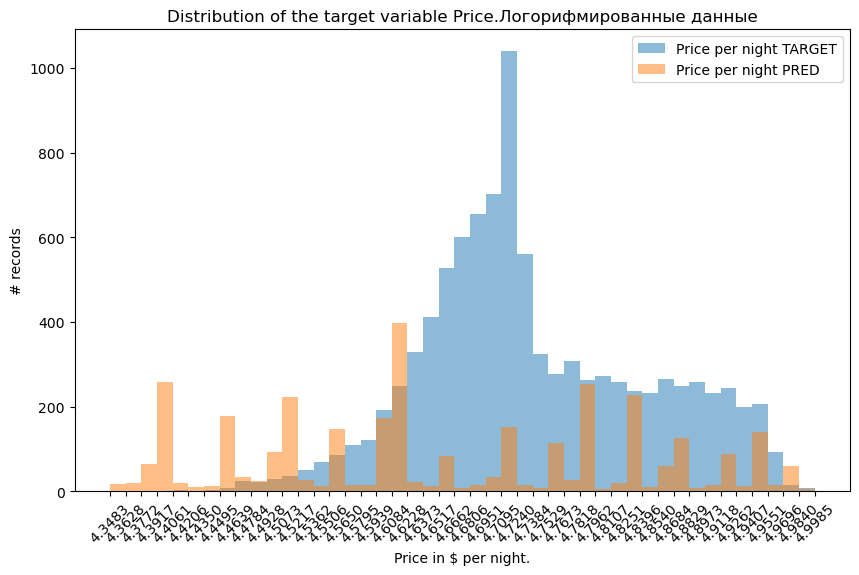

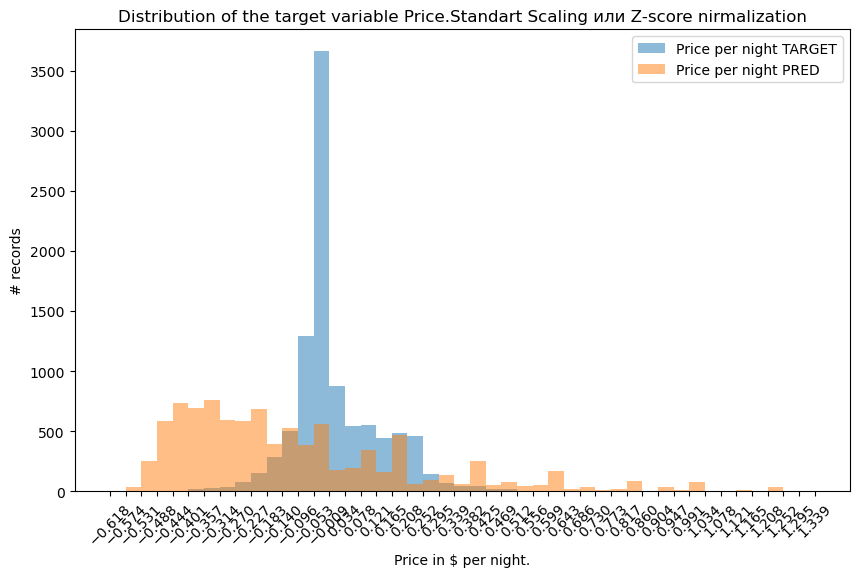

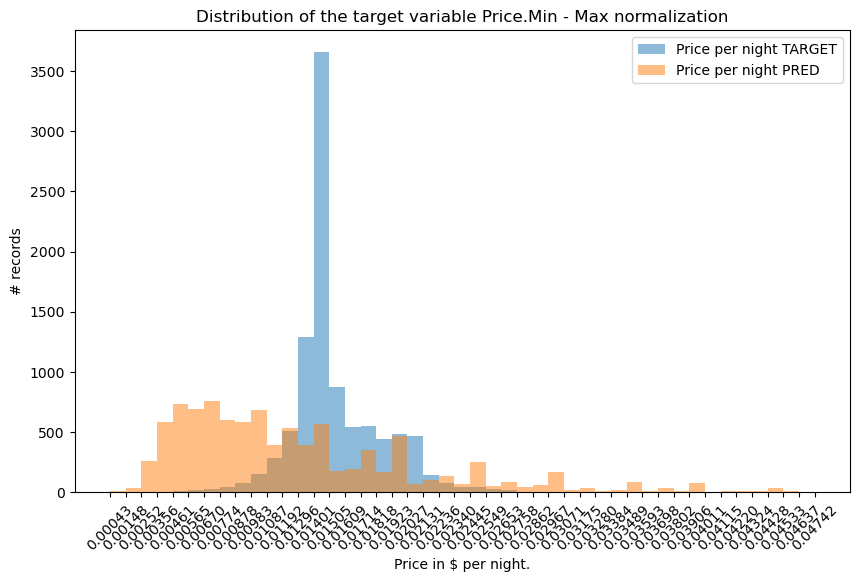

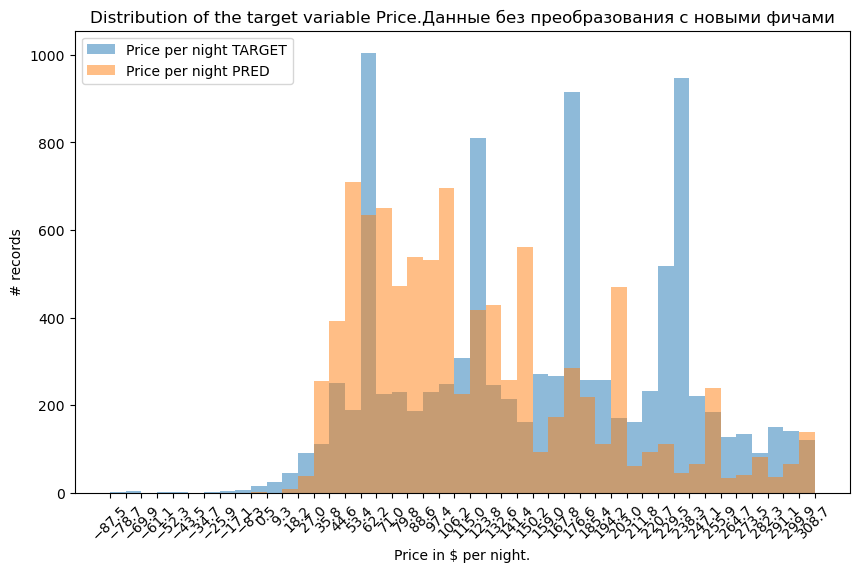

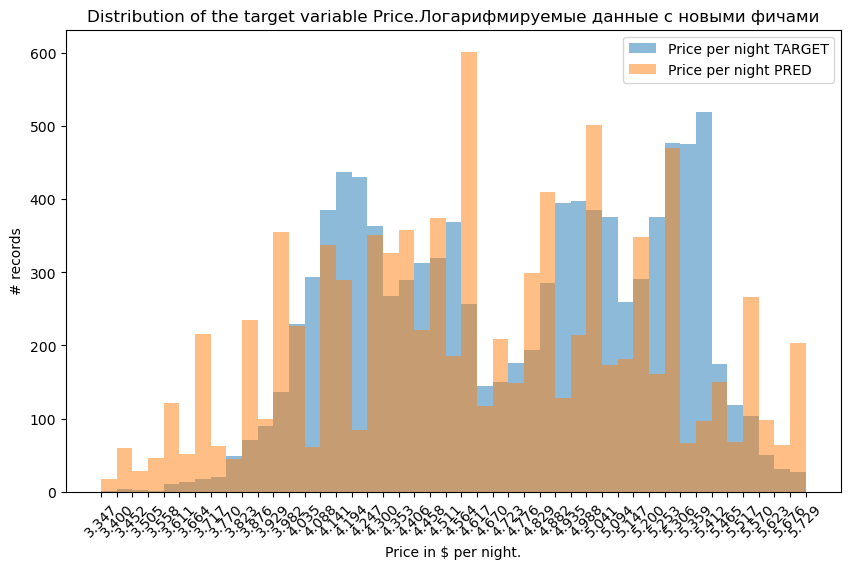

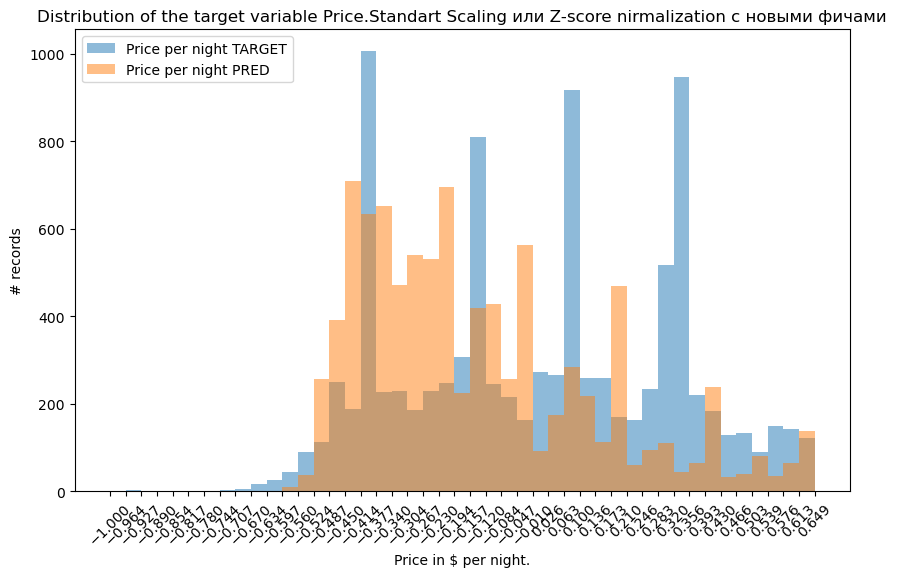

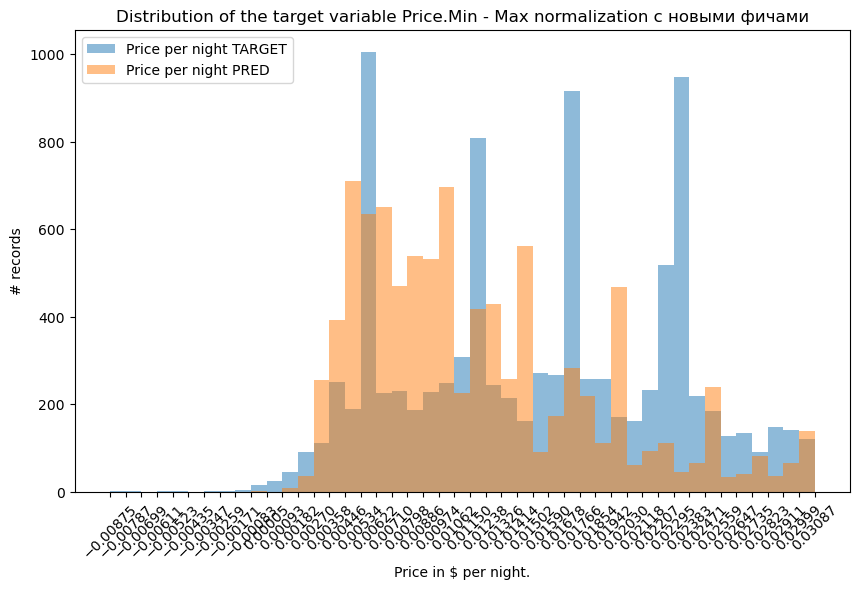

In [67]:
for data in list_of_instance_class:
    data0 = data.predict()
    data1 = data.y_val
    
    
    fig, ax = plt.subplots(figsize = (10,6))
    
    _,bins,_ = ax.hist(data0, label = 'Price per night TARGET', alpha = 0.5, bins = 45)
    ax.hist(data1, label = 'Price per night PRED', alpha = 0.5, bins = bins)
    
    ax.set_title('Distribution of the target variable Price.{name}'.format(name = data.name))
    ax.set_xlabel('Price in $ per night.')
    ax.set_ylabel('# records')
    ax.set_xticks(bins)
    ax.tick_params(axis='x', rotation = 45)
    ax.legend()
    plt.show()

# 12.Полиномиальная регрессия

#### Самое важное

Модель линейной регрессии можно сделать более гибкой, если использовать нелинейные функции от исходных предикторов (входных переменных) — такой подход называется полиномиальной регрессией.

* Чаще всего в качестве нелинейных функций используют степенные функции.
* С увеличением степени полинома модель начинает описывать данные, на которых обучается, всё лучше и лучше, даже слишком хорошо — начиная с определённой степени полинома это снижает обобщающую способность модели, то есть новые данные модель будет предсказывать хуже, чем обучающую выборку.


Ссылка на статью на Хабре.

https://habr.com/ru/articles/571058/

### ПРИМЕР:

In [68]:
array = np.array([0,1,2,3,4,5])

In [69]:
array.ndim

1

In [70]:
def generate_degrees(source_data: list, degree: int):
    """Функция, которая принимает на вход одномерный массив, а возвращает n-мерный
    
    Для каждой степени от 1 до  degree возводим x в эту степень
    """
    return np.array([
          source_data**n for n in range(1, degree + 1)  
    ]).T

In [71]:
generate_degrees(source_data= array, degree= 2)

array([[ 0,  0],
       [ 1,  1],
       [ 2,  4],
       [ 3,  9],
       [ 4, 16],
       [ 5, 25]])

In [72]:
poly = PolynomialFeatures(degree=2, interaction_only = False, include_bias=False).fit_transform(d_1.get('df_train'))
poly.shape

(29337, 20)

In [73]:
d_1.get('df_train').shape

(29337, 5)

Признаки второго порядка это все кмбинации каждого признака с каждым. 

#### Преобразуем наши данные ТОЛЬКО обучающие части. 

In [74]:
list_of_models_2 =[d_1_1, d_2_1, d_3_1, d_4_1]
for data in list_of_models_2:
    for X in ['df_train','df_val','df_test']:
        data[X] = PolynomialFeatures(degree=2).fit_transform(data.get(X))

In [75]:
list_of_instance_class = []
for data in list_of_models_2:
    instace = LinReg(
        df_train = data.get('df_train'), 
        y_train = data.get('y_train'), 
        df_val = data.get('df_val'), 
        y_val = data.get('y_val'), 
        df_test = data.get('df_test'), 
        y_test = data.get('y_test'), 
        name = data.get('name')
    )
    instace.fit()
    instace.loss()
    list_of_instance_class.append(instace)

Модель Данные без преобразования с новыми фичами, обучена.
Модель Данные без преобразования с новыми фичами.

Оценки модели на валидационной выборке:
MSE: 69905.8357014029 Лучше применять, когда выборке нет «выбросов» (от англ. outliers)
RMSE: 264.3971174226431 Чем ближе к нулю тем лучше! Если убрать выбросы - то метрика сильно улучшится.
MAE: 72.16036735708879 Если «выбросы» есть, лучше применять MAE.
r2score: -10.012588555073211 Наилучшее возможное значение 1.0. Если отрицательный - модель совсем уж плохая.

Модель Логарифмируемые данные с новыми фичами, обучена.
Модель Логарифмируемые данные с новыми фичами.

Оценки модели на валидационной выборке:
MSE: 0.23305840369398537 Лучше применять, когда выборке нет «выбросов» (от англ. outliers)
RMSE: 0.482761228449412 Чем ближе к нулю тем лучше! Если убрать выбросы - то метрика сильно улучшится.
MAE: 0.3488698478987448 Если «выбросы» есть, лучше применять MAE.
r2score: 0.07215562970354106 Наилучшее возможное значение 1.0. Если отрицательны

#### Добавление новых фичей и обучение с полиномами нам не сильно помогло, а в каких-то моментах и ухудшило наши метрики. P.S. обучение 6 степени полиномом заняло примерно 3 часа.

In [76]:
df_for_sr = pd.DataFrame([['Данные без преобразования', 75206.87, 274.23, 91.00, -84.25],
             ['Логорифмированные данные', 0.46, 0.68, 0.53, -41.71],
             ['Standart Scaling', 1.30, 1.14, 0.37, -84.25],
             ['Min - Max normalization', 0.00075, 0.027, 0.0091, -84.25],
             ['Данные без преобразования + 1', 70716.79, 265.92, 74.34, -11.62],
             ['Логарифмируемые данные + 1', 0.24, 0.49, 0.35, -0.0129],
             ['Standart Scaling + 1', 1.226, 1.107, 0.309, -11.62],
             ['Min - Max normalization + 1', 0.000707, 0.02659, 0.007434, -11.6239],
             ['Данные без преобразования + 1 + POL', 6193255536811.89, 3232145.14, 27917.98, -0.00011],
             ['Логарифмируемые данные + 1 + POL', 10446762250864.67, 2488625.23, 107884.33, -9.4288],                         
             ['Standart Scaling + 1 + POL', 915618155.92, 30259.18, 342.58, -9.3601],
             ['Min - Max normalization + 1 + POL', 467775077747.24, 683940.84, 7289.05, -0.00010659]])

In [77]:
df_for_sr.columns = ['Name of data', 'MSE', 'RMSE', 'MAE', 'r2score']
pd.options.display.float_format ='{:,.6f}'.format
df_for_sr

,Name of data,MSE,RMSE,MAE,r2score
0,Данные без преобразования,"75,206.870000",274.230000,91.000000,-84.250000
1,Логорифмированные данные,0.460000,0.680000,0.530000,-41.710000
2,Standart Scaling,1.300000,1.140000,0.370000,-84.250000
3,Min - Max normalization,0.000750,0.027000,0.009100,-84.250000
4,Данные без преобразования + 1,"70,716.790000",265.920000,74.340000,-11.620000
5,Логарифмируемые данные + 1,0.240000,0.490000,0.350000,-0.012900
6,Standart Scaling + 1,1.226000,1.107000,0.309000,-11.620000
7,Min - Max normalization + 1,0.000707,0.026590,0.007434,-11.623900
8,Данные без преобразования + 1 + POL,"6,193,255,536,811.889648","3,232,145.140000","27,917.980000",-0.000110
9,Логарифмируемые данные + 1 + POL,"10,446,762,250,864.669922","2,488,625.230000","107,884.330000",-9.428800


# 13.Регуляризация

Иногда при добавлении новых столбцов в Х мы можем случайно добавить столбец, представляющий собой комбинацию других столбцов. Когда подобное происходит - то произвдение транспонированной матрицы на себя становится неопределенной или сингулярной. В NumPy сообщит нам об этом.

Поэтой причине некоторые значения в весах становятся черезвычайно большими - намного больше, чем должны. 

In [78]:
list_of_instance_class[-1].model.coef_.max()

1310475337.684494

В численной линейной алгебре такие проблемы называются проблемами неустойчивости численного решения и обычно решаются с помощью методов регуляризации. 

Новые понятия:
* Переобучение (переподгонка, пере- в значении «слишком» (англ. overfitting)) — явление, когда построенная модель хорошо объясняет примеры из обучающей выборки, но относительно плохо работает на примерах, не участвовавших в обучении (на примерах из тестовой выборки). Переобучение имеет место при выборе слишком сложных моделей.
* Недообучение — это явление, обратное переобучению, при котором алгоритм не полностью использует предоставленные ему для обучения данные.
* Регуляризация — метод добавления некоторых дополнительных ограничений к условию с целью предотвращения переобучения. Она часто имеет вид штрафа за сложность модели.

Самое важное
* Для выбора корректных параметров модели, чтобы она не «оверфитнулась», можно использовать алгоритм, который называется «контроль на отложенной (валидационной) выборке»:
* Разбиваем обучающую выборку на две части: в одной части содержится 80% обучающих примеров (эта часть называется train set), в другой — 20% (эта часть называется validation set).
* Выбираем метрику качества модели (для регрессии, например, MSE).
* Обучаем модель на тренировочном наборе данных.
* Делаем предсказания на валидационном наборе данных и вычисляем метрику качества.
* Если качество на валидации значительно хуже, чем качество на обучающем датасете, модель переобучилась. Такую модель нельзя использовать, и с переобучением надо бороться.

    Один из способов борьбы с переобучением — регуляризация.
В стандартной библиотеке sklearn есть два класса, в которых реализована регуляризация:
* Ridge — класс библиотеки sklearn, реализующий линейную регрессию с **L1-регуляризацией**.* 
Lasso — класс библиотеки sklearn, реализующий линейную регрессию с **L2-регуляризацией**..

* sklearn.linear_model.Ridge https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html;
* sklearn.linear_model.Lasso https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html.

**ВАЖНО**

Выбор между двумя типами регуляризации:


* если фичей очень много (сотни) и среди них есть потенциально неважные, выбирай L1;
* если фичей мало и все они важны, выбирай L2.
Выбор коэффициента регуляризации можно осуществить с использованием контроля на валидационной выборке.

In [79]:
list_of_instance_class[-3].name

'Логарифмируемые данные с новыми фичами'

In [80]:
alphas = [0.1, 0.15, 0.35, 0.5, 0.8]

df_Ridge_res = pd.DataFrame(columns= ['Name of data', 'MSE', 'RMSE', 'MAE', 'r2score', 'alphas'])

for best_alpha in alphas:
    for data in list_of_instance_class:
        
        model_Ridge = Ridge(alpha=best_alpha)
        model_Ridge.fit(data.df_train, data.y_train)

        
        MSE = mean_squared_error(model_Ridge.predict(data.df_val), data.y_val, squared=True)
        RMSE = mean_squared_error(model_Ridge.predict(data.df_val), data.y_val, squared=False)
        MAE = mean_absolute_error(model_Ridge.predict(data.df_val), data.y_val,)
        r2score = r2_score(model_Ridge.predict(data.df_val), data.y_val,)


        newDict = {"Name of data": data.name,
                   "MSE": MSE,
                   "RMSE": RMSE,
                   "MAE": MAE,
                   "r2score": r2score,
                   "alphas" :best_alpha
                   }

        dfappend = pd.DataFrame([newDict])

        #df_Ridge_res = pd.concat([df_Ridge_res, dfappend])
        df_Ridge_res = (df_Ridge_res.copy() if dfappend.empty else dfappend.copy() if df_Ridge_res.empty
       else pd.concat([df_Ridge_res, dfappend]) # if both DataFrames non empty
      )
 

In [81]:
df_Ridge_res = pd.concat([df_for_sr.iloc[8:12],df_Ridge_res])
df_Ridge_res

,Name of data,MSE,RMSE,MAE,r2score,alphas
8,Данные без преобразования + 1 + POL,"6,193,255,536,811.889648","3,232,145.140000","27,917.980000",-0.000110,NaN
9,Логарифмируемые данные + 1 + POL,"10,446,762,250,864.669922","2,488,625.230000","107,884.330000",-9.428800,NaN
10,Standart Scaling + 1 + POL,"915,618,155.920000","30,259.180000",342.580000,-9.360100,NaN
11,Min - Max normalization + 1 + POL,"467,775,077,747.239990","683,940.840000","7,289.050000",-0.000107,NaN
0,Данные без преобразования с новыми фичами,"69,905.631560",264.396731,72.159433,-10.013231,0.100000
0,Логарифмируемые данные с новыми фичами,0.233062,0.482765,0.348876,0.072104,0.100000
0,Standart Scaling или Z-score nirmalization с н...,1.212022,1.100919,0.300396,-10.023598,0.100000
0,Min - Max normalization с новыми фичами,0.000699,0.026441,0.007198,-10.102882,0.100000
0,Данные без преобразования с новыми фичами,"69,905.538920",264.396556,72.159271,-10.013524,0.150000
0,Логарифмируемые данные с новыми фичами,0.233064,0.482767,0.348879,0.072081,0.150000


In [82]:
model_Ridge = Ridge(alpha=0.8)
model_Ridge.fit(list_of_instance_class[-3].df_train, list_of_instance_class[-3].y_train)
MAE_train = mean_absolute_error(model_Ridge.predict(list_of_instance_class[-3].df_train), list_of_instance_class[-3].y_train)
MAE_val = mean_absolute_error(model_Ridge.predict(list_of_instance_class[-3].df_val), list_of_instance_class[-3].y_val)
MAE_test = mean_absolute_error(model_Ridge.predict(list_of_instance_class[-3].df_test), list_of_instance_class[-3].y_test)
newDict = {"Name of data": list_of_instance_class[-3].name,
                   "MAE_train": MAE_train,
                   "MAE_val": MAE_val,
                   "MAE_test": MAE_test
                   }
dfappend = pd.DataFrame([newDict])
dfappend

,Name of data,MAE_train,MAE_val,MAE_test
0,Логарифмируемые данные с новыми фичами,0.354412,0.348901,0.355343


In [83]:
data_for_pred = list_of_instance_class[-3].df_test[0]
y_for_pred = list_of_instance_class[-3].y_test[21494]
price = model_Ridge.predict(data_for_pred.reshape(1, -1))
price = np.expm1(price)
print ('Предсказанная цена: {price} \nЦена из датасета: {df_p}'.format(price=price[0], df_p=df.iloc[21494, 9]))

Предсказанная цена: 53.84012455816829 
Цена из датасета: 64


# 14. Переобучение на примере модели линейной регрессии

**Смотри пункт 13**

# 15. Подбор гиперпараметров

HalvingSearch: ускорение поиска по сетке (grid search).

https://scikit-learn.org/stable/modules/grid_search.html#successive-halving-user-guide

Метод реализован для регрессии и классификации. Принцип работы обоих вариантов одинаков.

Halving здесь означает «уполовинивание», т.е. деление на две части, хотя на практике используется деление на произвольное число частей (чаще всего на три).

Ниже модели с разными наборами гиперпараметров будем называть «кандидатами».

Идея в том, что проверку можно ускорить, уменьшив число объектов в учебном наборе данных. Однако при этом снижается точность прогноза, поэтому для окончательного отбора кандидатов лучше использовать все имеющиеся данные

# ИТОГИ:

* Важно проводить первоначальный исследовательский анализ. Важно проверить данные на пропущенные значения.
* Проверять распределение целевой переменной. Если целевое распределение имеет длинный хвост, то следует применить логарифмическое преобразования.
* Разделение данных на обучающие проверочные и тестовые - лучший способ проверить наши модели.
* Оценки качества позволяют сравнить модели между собой.
* Конструирование признаков - процесс создания новых признаков.
* Проблемы неустойчивости численного решения помогает решить регуляризация.

# Градиентный спуск. SGDRegressor.

У аналитического решения задачи расчёта коэффициентов регрессии есть ряд недостатков, в том числе:

1. вычислительная сложность из-за матричного перемножения. При увеличении размерности матрицы в 10 раз сложность вычислений увеличивается в 1000 раз;
2. неустойчивость вычислений: при попытке найти обратную матрицу, которая может не существовать, в алгоритме нахождения обратной матрицы возникает деление на ноль.

Избежать этих проблем можно с помощью приближённых численных методов. При этом не надо будет перемножать матрицы или находить обратные матрицы. Самый простой и эффективный из этих методов называется методом градиентного спуска. Суть метода состоит в обновлении параметров модели 𝑤 по маленьким шажкам вместо того, чтобы находить их сразу. Каждый такой шажок называется итерацией.

**Когда следует использовать градиентный спуск** 
* Когда данных очень много - нехватит памяти у компьютера;
* Когда нужно контролировать точность обучения;
  
**Когда не стоит применять градиентный спукс**
* Когда данных мало. В этом случае лучше использовать Ridge или Lasso.

sklearn.linear_model.SGDRegressor — класс библиотеки sklearn, в котором реализован градиентный спуск. Класс принимает следующие параметры:

1. learning_rate='constant' — используем самую простую модификацию спуска из нескольких возможных (см. документацию);
2. eta0 — шаг градиентного спуска;
3. fit_intercept — даёт возможность обучить коэффициент при свободном члене линейной регрессии;
4. random_state — этот параметр нужен для воспроизводимости вычислений
5. alpha - Константа, умножающая член регуляризации. Чем выше значение, тем сильнее регуляризация. .

Метод partial_fit() делает одну итерацию градиентного спуска.

In [84]:
from sklearn.linear_model import SGDRegressor
from scipy.spatial import distance

#### Пробуем большие данные с Ridge

In [91]:
# Делаем очень большие данные
for X in ['df_train','df_val','df_test']:
        d_2_1[X] = PolynomialFeatures(degree=2).fit_transform(d_2_1.get(X))

MemoryError: Unable to allocate 1.95 TiB for an array with shape (29337, 9157060) and data type float64

In [89]:
d_2_1['df_val'].shape

(9779, 4278)

In [98]:
model_Ridge = Ridge(alpha=0.8)
model_Ridge.fit(d_2_1['df_train'], d_2_1['y_train'])
MAE_train = mean_absolute_error(model_Ridge.predict(d_2_1['df_train']), d_2_1['y_train'])
MAE_val = mean_absolute_error(model_Ridge.predict(d_2_1['df_val']), d_2_1['y_val'])
MAE_test = mean_absolute_error(model_Ridge.predict(d_2_1['df_test']), d_2_1['y_test'])
newDict = {"Name of data": d_2_1['name'],
                   "MAE_train": MAE_train,
                   "MAE_val": MAE_val,
                   "MAE_test": MAE_test
                   }
dfappend = pd.DataFrame([newDict])
dfappend

,Name of data,MAE_train,MAE_val,MAE_test
0,Логарифмируемые данные с новыми фичами,0.344344,0.347221,0.354352


#### Сингулярная матрица

In [101]:
matrix = ([[2, 1],
           [4, 2]])

np.linalg.inv(matrix)

LinAlgError: Singular matrix

#### Градиентный спуск.

[7.37738147e-01 9.44725134e-02 2.76462842e-01 7.37979504e-01
 4.05474216e-01 1.08979073e-01 2.09369879e-01 1.82622807e-01
 1.34624580e-01 5.20086852e-01 9.94139065e-01 1.29772961e-01
 3.14000926e-01 3.82641209e-01 2.81186662e-02 6.49394721e-01
 7.48585513e-01 2.16380270e-01 5.90686094e-01 4.22714754e-01
 3.56552979e-01 2.26516867e-01 8.66898621e-01 8.85858277e-01
 1.80858813e-01 6.95730212e-01 6.02726262e-02 8.51360479e-01
 1.00979193e-01 1.10343997e-01 5.16255342e-01 1.78003314e-01
 3.30918600e-01 3.91059878e-01 3.75755589e-05 8.07063994e-01
 8.58293400e-02 4.99028728e-01 5.07733584e-01 4.74652428e-01
 6.67684964e-01 4.89442289e-01 6.48227376e-01 1.22383729e-01
 8.69446889e-01 4.80142007e-01 9.35827410e-01 3.99901160e-01
 5.90419285e-01 1.92145188e-01 9.44091532e-01 1.35821060e-01
 4.18718761e-01 3.80979704e-02 7.68205740e-01 1.31066250e-01
 2.11163185e-01 3.62464313e-01 6.32099496e-01 6.46197799e-01
 6.59531924e-01 6.79236049e-01 8.76457682e-01 2.03976915e-01
 3.45422004e-01 4.872503

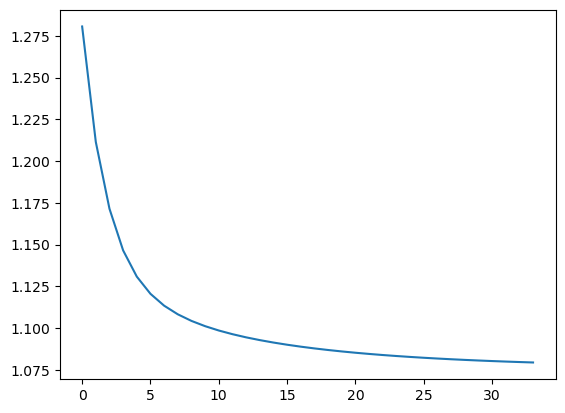

In [102]:
sgd_regressor = SGDRegressor(learning_rate= 'constant', eta0= 0.001, alpha = 0.01, fit_intercept= True, random_state= 42)

# Сделаем 1000 шагов градиентного спуска
weight_evo = [] #Для записи измерения весов
mae_evo = [] #Для измерения ошибки

w_current = np.random.random(list_of_instance_class[-3].df_train.shape[1]) #для записи коефиw, сгенерим начальные веса (по количеству фичей)
epsilon = 0.01 # запись нашего минимума, т.е. на когда наши веса начнуть меняться менее данного числа - то мы нашли мин
print(w_current)
print('Количество весовых коэффициентов: ',len(w_current))

for step in list(range(1000)):
    sgd_regressor = sgd_regressor.partial_fit(list_of_instance_class[-3].df_train, list_of_instance_class[-3].y_train) #обучаем модельку
    weight_evo.append(distance.euclidean(w_current, sgd_regressor.coef_)) #запоминаем изменение весов от тек знач
    if weight_evo[-1] < epsilon:
        print("\nИтерации остановлены на шаге %d" %step); break # проверка выхода из цикла
    current_error = mean_absolute_error(list_of_instance_class[-3].y_val, sgd_regressor.predict(list_of_instance_class[-3].df_val))
    mae_evo.append(current_error) #считаем ошибку
    w_current = sgd_regressor.coef_.copy()

print('Количество шагов : ', step)
print('Значение последней предыдущией ошибки и последней ошибки : ',mae_evo[-2], current_error)
print('Длинна списка ошибок :', len(mae_evo))
   
fig, ax = plt.subplots()
ax.plot(range(step), mae_evo, label = 'd')
plt.show()